# Predicting-Customer-Churn-using-Feed-Forward-Neural-Networks



**Customer churn** is a financial term that refers to the loss of a client or customer—that is, when a customer ceases to interact with a company or business. Similarly, the churn rate is the rate at which customers or clients are leaving a company within a specific period of time. A churn rate higher than a certain threshold can have both tangible and intangible effects on a company's business success. Ideally, companies like to retain as many customers as they can.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os

### Get the Data

Data source: https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset

In [3]:
# load and preview data

df = pd.read_excel('Telco_customer_churn.xlsx')

df.head()

# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/MyDrive/Colab Notebooks/Telco_customer_churn.xlsx'

# import pandas as pd
# df = pd.read_excel(file_path)

# df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
# view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [5]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [6]:
# Drop columns which are not required for model building
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis=1, inplace=True)

In [7]:
df['Count'].unique()

array([1])

In [8]:
df['Country'].unique()

array(['United States'], dtype=object)

In [9]:
df['State'].unique()

array(['California'], dtype=object)

In [10]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [11]:
# Drop more columns
df.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long'], axis=1, inplace=True)

df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [12]:
df['City'].replace(' ', '_', regex=True, inplace=True)

df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [13]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

In [14]:
# Convert column names too
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

In [15]:
# Columns type
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [16]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

In [17]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

In [18]:
# See how many occurrences
len(df.loc[df['Total_Charges']==' '])

11

In [19]:
# Let's look them
df.loc[df['Total_Charges']==' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [20]:
# Set the 'Total_Charges' to 0 in these 11 cases, ' ' to zero.

df.loc[(df['Total_Charges']==' '), 'Total_Charges'] = 0

In [21]:
# Check
len(df.loc[df['Total_Charges']==' '])

0

In [22]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

In [23]:
# Now, let's do the same for All DataFrame.

df.replace(' ', '_', regex=True, inplace=True)

df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


### Split the Data

In [24]:
X = df.drop('Churn_Value', axis=1).copy()

y = df['Churn_Value'].copy()

In [25]:
df['Payment_Method'].unique()

array(['Mailed_check', 'Electronic_check', 'Bank_transfer_(automatic)',
       'Credit_card_(automatic)'], dtype=object)

In [26]:
#set df view to show all columns
pd.set_option('display.max_columns', None)

In [27]:
# One-Hot Encoding View
pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,53.85,108.15,False,False,False,True
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,70.70,151.65,False,False,True,False
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,99.65,820.50,False,False,True,False
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,104.80,3046.05,False,False,True,False
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,103.70,5036.30,True,False,False,False


In [28]:
X.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges'],
      dtype='object')

In [29]:
# shape
X.shape

(7043, 23)

In [30]:
# number of unique values in each object column
X.select_dtypes('object').nunique()


City                 1129
Gender                  2
Senior_Citizen          2
Partner                 2
Dependents              2
Phone_Service           2
Multiple_Lines          3
Internet_Service        3
Online_Security         3
Online_Backup           3
Device_Protection       3
Tech_Support            3
Streaming_TV            3
Streaming_Movies        3
Contract                3
Paperless_Billing       2
Payment_Method          4
dtype: int64

In [31]:
#drop City
X.drop('City', axis=1, inplace=True)

In [32]:
# Let's do it for all qualitative columns

X_encoded = pd.get_dummies(X, columns=[
                                       'Gender',
                                       'Senior_Citizen',
                                       'Partner',
                                       'Dependents',
                                       'Phone_Service',
                                       'Multiple_Lines',
                                       'Internet_Service',
                                       'Online_Security',
                                       'Online_Backup',
                                       'Device_Protection',
                                       'Tech_Support',
                                       'Streaming_TV',
                                       'Streaming_Movies',
                                       'Contract',
                                       'Paperless_Billing',
                                       'Payment_Method'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Gender_Female,Gender_Male,Senior_Citizen_No,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
1,90005,34.059281,-118.307420,2,70.70,151.65,True,False,True,False,True,False,False,True,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
2,90006,34.048013,-118.293953,8,99.65,820.50,True,False,True,False,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False
3,90010,34.062125,-118.315709,28,104.80,3046.05,True,False,True,False,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False
4,90015,34.039224,-118.266293,49,103.70,5036.30,False,True,True,False,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,True,True,False,False,False


In [33]:
# Verify 'y'
y.unique()

array([1, 0])

In [34]:
# Lets see how imbalance is this dataset looking for y=1:
sum(y) / len(y)

0.2653698707936959

In [35]:
# Split the trains and tests
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [36]:
# target class distribution
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

y_train class distribution
Churn_Value
0    0.73457
1    0.26543
Name: proportion, dtype: float64


## Neural Net Architecture

In [43]:
# Define the network
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32)).unsqueeze(1)

print('Tensor formed for X_train:', X_train_tensor.shape)
print('Tensor formed for y_train:', y_train_tensor.shape)
print('Tensor formed for X_test:', X_test_tensor.shape)
print('Tensor formed for y_test:', y_test_tensor.shape)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print('Train dataset:', len(train_dataset))
print('Test dataset:', len(test_dataset))

batch_size = 100  # You can adjust this
num_workers = os.cpu_count()  # Use all available CPU cores
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print('Train loader:', len(train_loader))
print('Test loader:', len(test_loader))


# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 50
model = BinaryClassifier(input_size, hidden_size1, hidden_size2)

print('model initialized')

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted

print('criterion and optimizer initialized')

# Number of epochs
epochs = 200

for epoch in range(epochs):
    for inputs, labels in train_loader:
        # Forward pass
        # print("in forward pass of epoch:", epoch+1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1)%10==0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Tensor formed for X_train: torch.Size([5282, 49])
Tensor formed for y_train: torch.Size([5282, 1])
Tensor formed for X_test: torch.Size([1761, 49])
Tensor formed for y_test: torch.Size([1761, 1])
Train dataset: 5282
Test dataset: 1761
Train loader: 53
Test loader: 18
model initialized
criterion and optimizer initialized
Epoch [10/200], Loss: 73.1707
Epoch [20/200], Loss: 73.1707
Epoch [30/200], Loss: 74.3902
Epoch [40/200], Loss: 75.6098
Epoch [50/200], Loss: 80.4878
Epoch [60/200], Loss: 78.0488
Epoch [70/200], Loss: 71.9512
Epoch [80/200], Loss: 74.3902
Epoch [90/200], Loss: 73.1707
Epoch [100/200], Loss: 71.9512
Epoch [110/200], Loss: 74.3902
Epoch [120/200], Loss: 73.1707
Epoch [130/200], Loss: 65.8537
Epoch [140/200], Loss: 71.9512
Epoch [150/200], Loss: 78.0488
Epoch [160/200], Loss: 78.0488
Epoch [170/200], Loss: 62.1951
Epoch [180/200], Loss: 73.1707
Epoch [190/200], Loss: 76.8293
Epoch [200/200], Loss: 75.6098


In [39]:
 # Evaluate the model on the test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

        # Convert output probabilities to predicted class (0 or 1)
        predicted = torch.round(outputs)

        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / total

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy*100:.2f}%')

Test Loss: 73.4517
Test Accuracy: 26.52%


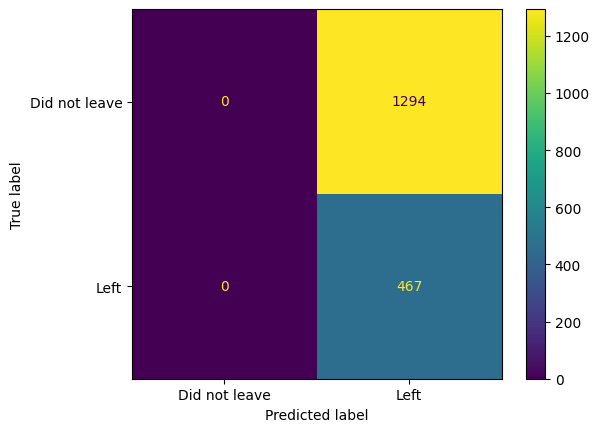

In [42]:
# Predictions - Neural Network outputs probabilities
y_pred_prob = model(X_test_tensor).detach().numpy()
# Convert probabilities to binary predictions based on a 0.5 threshold
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not leave', 'Left'])

# Plot the confusion matrix
disp.plot(values_format='d')
plt.show()